# Evaluate results with the Brier Skill Score (BSS)
In this notebook, we will now evaluate the quality of our forecasts using the BSS. The BSS is a probabilistic metric, and provides another perspective on the usefullness of a forecast than the AUC under the ROC.

## Import libraries

In [1]:
import numpy as np
#%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import feather

## Load GLM results
We will use results from the GLM forecasting. We will use forecasts made with IEA history, seizure history, and multidien rhythms.

The columns of interest here are: 
   - patient: the name of the patient
   - preds_test: the forecasted values on the test dataset
   - test_Sz: if there is a seizure or not happening at that particular time point
   - cov_choice: the name of the covariate used for that prediction

In [2]:
results_sz_IEA_history = feather.read_dataframe(r'data/all_patients_ts_test_day_acausal4.feather')
results_multi = feather.read_dataframe(r'data/all_patients_no_cross_auto_ts_test_day_acausal4.feather')
results = pd.concat([results_sz_IEA_history, results_multi])
results = results[~results['score_method'].isna()] # we remove a few Nan lines
results[['patient', 'preds_test', 'test_Sz', 'cov_choice']]

,patient,preds_test,test_Sz,cov_choice
1,BJ,0.127896,0.0,only_cross
2,BJ,0.229434,0.0,only_cross
3,BJ,0.371381,0.0,only_cross
4,BJ,0.099135,1.0,only_cross
5,BJ,0.093314,0.0,only_cross
...,...,...,...,...
8454,WP,0.707840,0.0,phase_multi
8455,WP,0.708469,0.0,phase_multi
8456,WP,0.611408,0.0,phase_multi
8457,WP,0.465036,1.0,phase_multi


We select forecasts for patient JE and for our three covariates.

In [3]:
patient = "JE"
predictions_sz = results[(results['patient']==patient) & 
                         (results['cov_choice']=='only_auto')]['preds_test'].to_numpy()
predictions_IEA = results[(results['patient']==patient) & 
                          (results['cov_choice']=='only_cross')]['preds_test'].to_numpy()
predictions_multi = results[(results['patient']==patient) & 
                            (results['cov_choice']=='phase_multi')]['preds_test'].to_numpy()[2:]

We also select the seizures, which are the same for the three covariates.

In [4]:
seizures = results[(results['patient']==patient) & (results['cov_choice']=='only_cross')]['test_Sz'].to_numpy().astype('int')

Plot the predictions for each covariate and the actual seizures

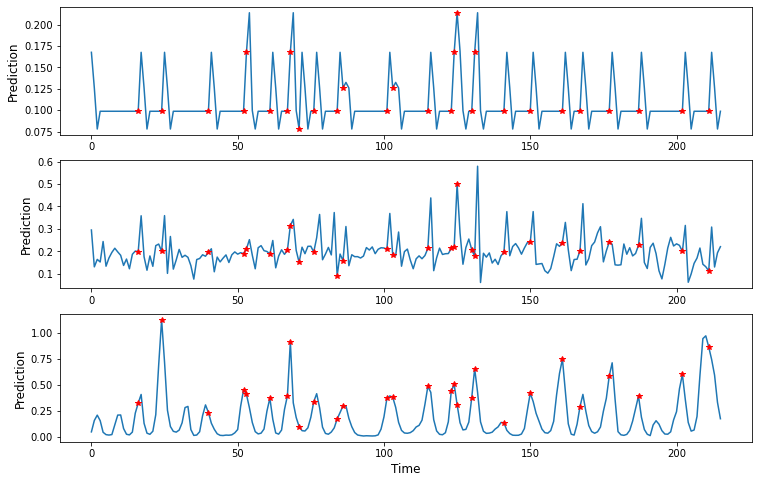

In [5]:
fig, axs = plt.subplots(3, 1,figsize=(12.4, 8))
axs[0].plot(predictions_sz)
axs[0].plot(np.nonzero(seizures)[0], predictions_sz[seizures==1],'r*')
axs[1].plot(predictions_IEA)
axs[1].plot(np.nonzero(seizures)[0], predictions_IEA[seizures==1],'r*')
axs[2].plot(predictions_multi)
axs[2].plot(np.nonzero(seizures)[0], predictions_multi[seizures==1],'r*')
axs[2].set_xlabel('Time',fontsize=12)
for i in range(3): axs[i].set_ylabel('Prediction',fontsize=12)
plt.show();

## Plot the reliability diagram
A reliability diagram is a plot showing the probability of observing q seizure computed from the data (y-axis) versus the probability predicted by the forecaster. Thus, it shows the general ability of a forecaster to compute the right probabilities.<br>
To ensure that the reliability diagram is equally weighted for each data point in the plot, we want to make sure that we have the same amount of data which are use to compute each datapoint. For this, we first divide the forecasts into bins such that each bin that contains the same amount of datapoints. We divide our forecasts in 20 bins, with the same amount of forecast in each bin. For simplicity, we will here base our bins on the multidien forecasts.

In [6]:
bin_edges_sz = list(stats.mstats.mquantiles(predictions_sz, np.arange(0., 1., 0.05)))
bin_edges_IEA = list(stats.mstats.mquantiles(predictions_IEA, np.arange(0., 1., 0.05)))
bin_edges_multi = list(stats.mstats.mquantiles(predictions_multi, np.arange(0., 1., 0.05)))

Then, for all forecasted values that fall into the bin, we compute the corresponding likelihood of observing a seizure.

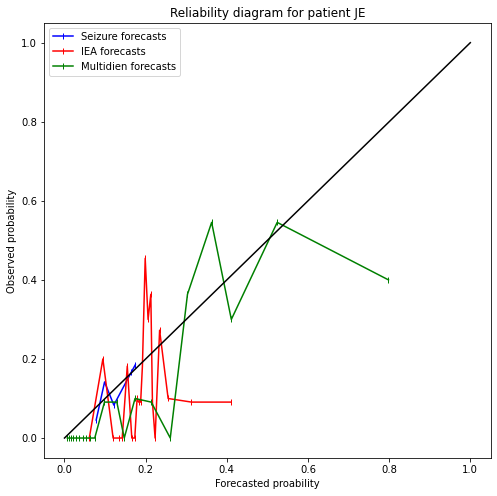

In [7]:
fig, axs = plt.subplots(1, 1,figsize=(8, 8))
all_edges = [[0, *bin_edges_sz, 1], [0, *bin_edges_IEA, 1], [0, *bin_edges_multi, 1]]
lcolors = ['b', 'r', 'g']
labels = ['Seizure forecasts', 'IEA forecasts', 'Multidien forecasts']
for ipred, preds in enumerate([predictions_sz, predictions_IEA, predictions_multi]):
    bin_preds, bin_observed = [], []
    ledges= all_edges[ipred]
    for ixbin, xbin in enumerate(ledges[:-1]):
        curr_y = seizures[(preds>xbin) & (preds<=ledges[ixbin+1])]
        if curr_y.shape[0]>0:
            bin_observed.append(np.sum(curr_y)/curr_y.shape[0])
            bin_preds.append(np.mean(preds[(preds>xbin) & (preds<=ledges[ixbin+1])]))
    plt.plot(bin_preds, bin_observed, marker='|', color=lcolors[ipred], label=labels[ipred])
plt.plot([0, 1], [0, 1], 'k')
plt.xlabel('Forecasted proability')
plt.ylabel('Observed probability')
plt.title('Reliability diagram for patient JE')
plt.legend();

How good a forecast follow the diagonal line is called the calibration. A perfect forecast will follow exactly the diagonal line (the predicted probability corresponds exactly to the observed probability), while a random forecast will follow a horizontal line (the observed probability is independent of the forecasted probability).
As you can see, the resulting time series look very noisy. This is because we need a large amount of data (i.e. a long test set with many seizures) to properly evaluate probabilities in each bin. Our example patient had 868 days in the test set.<br>

## Brier skill score (BSS)
We will now compute the Brier skill score.<br>
For this, we first need to comput the Brier score, which is obtained by comparing the mean euclidean distance between forecasts and the actual observed values.

In [8]:
BS = [np.mean((predictions_sz - seizures)**2),
      np.mean((predictions_IEA - seizures)**2),
      np.mean((predictions_multi - seizures)**2)]
print('BS seizures: %.3f, BS IEA: %.3f, BS multidien: %.3f' % tuple(BS))

BS seizures: 0.113, BS IEA: 0.120, BS multidien: 0.092


We now need to compute a reference forecast that corresponds to the chance level. Several choices are possible, we choose a boostrapping method where we repetitively (1000 times) draw forecasts randomly from our actual forecasts, and compute the average Brier score across all repetitions.

In [9]:
BS_refs = []
for preds in [predictions_sz, predictions_IEA, predictions_multi]:
    BS_ref = []
    for irandom in range(1000):
        shuffle_preds = np.random.choice(preds, preds.shape[0])
        BS_ref.append(np.mean((shuffle_preds - seizures)**2))
    BS_refs.append(np.mean(BS_ref))
print('reference BS seizures: %.3f, reference BS IEA: %.3f, reference BS multidien: %.3f' % tuple(BS_refs))

reference BS seizures: 0.114, reference BS IEA: 0.123, reference BS multidien: 0.160


The BSS is then obtained via the following formula.

In [10]:
BSS = 1 - (np.array(BS)/np.array(BS_refs))
print('BSS seizures: %.3f, BSS IEA: %.3f, BSS multidien: %.3f' % tuple(BSS))

BSS seizures: 0.011, BSS IEA: 0.022, BSS multidien: 0.426


We now compute the BSS across all our subjects, by doing the same thing than above, but for all patients.

In [11]:
BSS_all_patients = []
for patient in results['patient'].unique():
    predictions_sz = results[(results['patient']==patient) & (results['cov_choice']=='only_auto')]['preds_test'].to_numpy()
    predictions_IEA = results[(results['patient']==patient) & (results['cov_choice']=='only_cross')]['preds_test'].to_numpy()
    predictions_multi = results[(results['patient']==patient) & (results['cov_choice']=='phase_multi')]['preds_test'].to_numpy()[2:]
    seizures = results[(results['patient']==patient) & (results['cov_choice']=='only_cross')]['test_Sz'].to_numpy().astype('int')
    BS = [np.mean((predictions_sz - seizures)**2),
          np.mean((predictions_IEA - seizures)**2),
          np.mean((predictions_multi - seizures)**2)]
    BS_refs = []
    for preds in [predictions_sz, predictions_IEA, predictions_multi]:
        BS_ref = []
        for irandom in range(1000):
            shuffle_preds = np.random.choice(preds, preds.shape[0])
            BS_ref.append(np.mean((shuffle_preds - seizures)**2))
        BS_refs.append(np.mean(BS_ref))
    BSS_all_patients.append(1 - (np.array(BS)/np.array(BS_refs)))

We plot the results in three boxplot, one for each of the covariates

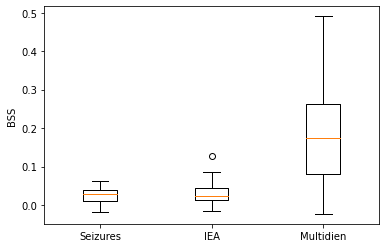

In [12]:
plt.boxplot(np.array(BSS_all_patients))
plt.xticks(range(1,4), ['Seizures', 'IEA', 'Multidien'])
plt.ylabel('BSS');

## Simulations

We will use the same simulations that we used in the previous notebook, i.e. an inhomogeneous Poisson process with harmonic conditional intensity.

The underlying rhythm is a cosine function with a fixed period of 30 days. In our first model, both underlying rhythms, IEA (X) and Seizures (X_Seiz) share the same periodicity. The phase-shift indicates the shift between the IEA and seizures.

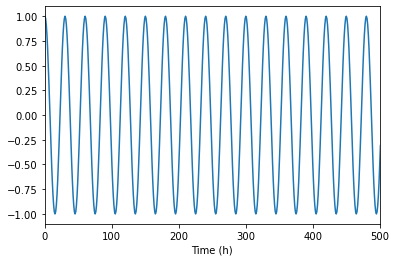

In [13]:
T = 10000
t = np.arange(0,T)
period = 30 
x = np.cos((2*np.pi/(period))*t)
plt.figure()
plt.plot(x)
plt.xlim([0, 500])
plt.xlabel('Time (h)')
plt.show()

We then generate the conditional intensity, i.e. the "true (or latent) likelihood" of seizures, that will determine the probability that a seizure is observed, and from which we will draw seizures (random realization based on this conditional intensity).

In [14]:
sz_level = 5.5
lambda_sz, sz = [], []
for ix in x:               
    lambda_sz.append(np.exp(-5.5 +  sz_level*ix))
    p = lambda_sz[-1]
    if p > np.random.uniform():    
        sz.append(1)
    else:
        sz.append(0)
lambda_sz, sz = np.array(lambda_sz), np.array(sz)

Plot the simulated data.

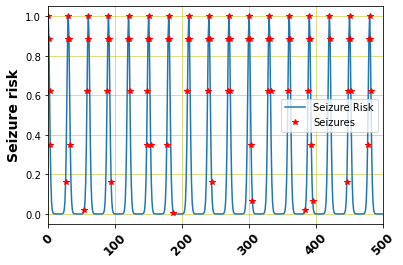

In [15]:
plt.figure()
plt.plot(t,lambda_sz)
plt.plot(t[sz==1], lambda_sz[sz==1],'r*')
plt.ylabel('Seizure risk', weight='bold', fontsize=14)
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.grid(color = 'y', linewidth='0.5')
plt.legend(['Seizure Risk','Seizures'])
plt.xlim([0, 500])
plt.show();

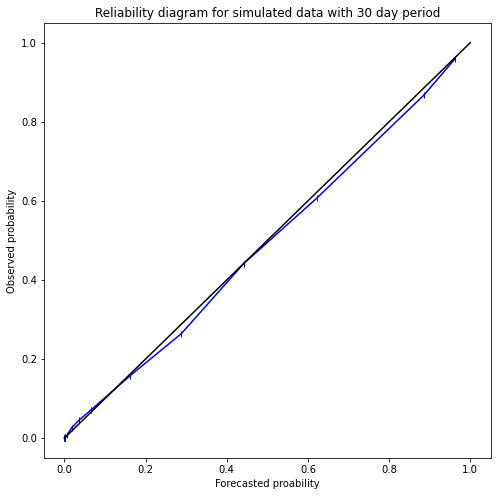

In [16]:
bin_edges = list(stats.mstats.mquantiles(lambda_sz, np.arange(0., 1., 0.05)))
fig, axs = plt.subplots(1, 1, figsize=(8, 8))
bin_preds, bin_observed = [], []
ledges = [0, *bin_edges, 1]
for ixbin, xbin in enumerate(ledges[:-1]):
    curr_y = sz[(lambda_sz>xbin) & (lambda_sz<=ledges[ixbin+1])]
    if curr_y.shape[0]>0:
        bin_observed.append(np.sum(curr_y)/curr_y.shape[0])
        bin_preds.append(np.mean(lambda_sz[(lambda_sz>xbin) & (lambda_sz<=ledges[ixbin+1])]))
plt.plot(bin_preds, bin_observed, marker='|', color='b')
plt.plot([0, 1], [0, 1], 'k')
plt.xlabel('Forecasted proability')
plt.ylabel('Observed probability')
plt.title('Reliability diagram for simulated data with 30 day period');

You can see here that the forecast is well calibrated, as expecte.

We now compute a second simulated time series with the same underlying time course of the probability of observing seizures over time, but with a small intensity overall. By doing so, we also change how much the classification problem is unbalanced.

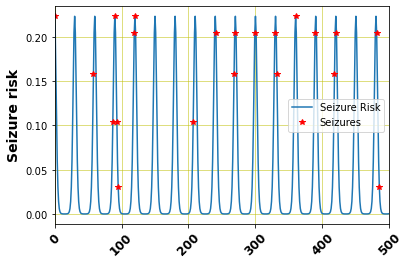

In [17]:
sz_level = 4
lambda_sz2, sz2 = [], []
for ix in x:               
    lambda_sz2.append(np.exp(-5.5 +  sz_level*ix))
    p = lambda_sz2[-1]
    if p > np.random.uniform():    
        sz2.append(1)
    else:
        sz2.append(0)
lambda_sz2, sz2 = np.array(lambda_sz2), np.array(sz2)

plt.figure()
plt.plot(t,lambda_sz2)
plt.plot(t[sz2==1], lambda_sz2[sz2==1],'r*')
plt.ylabel('Seizure risk', weight='bold', fontsize=14)
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.grid(color = 'y', linewidth='0.5')
plt.legend(['Seizure Risk','Seizures'])
plt.xlim([0, 500])
plt.show();

We plot the reliability diagram for this time series.

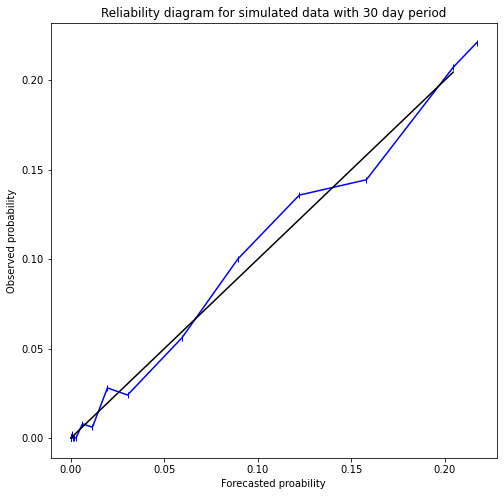

In [18]:
bin_edges = list(stats.mstats.mquantiles(lambda_sz2, np.arange(0., 1., 0.05)))
fig, axs = plt.subplots(1, 1, figsize=(8, 8))
bin_preds, bin_observed = [], []
ledges = [0, *bin_edges, 1]
for ixbin, xbin in enumerate(ledges[:-1]):
    curr_y = sz2[(lambda_sz2>xbin) & (lambda_sz2<=ledges[ixbin+1])]
    if curr_y.shape[0]>0:
        bin_observed.append(np.sum(curr_y)/curr_y.shape[0])
        bin_preds.append(np.mean(lambda_sz2[(lambda_sz2>xbin) & (lambda_sz2<=ledges[ixbin+1])]))
plt.plot(bin_preds, bin_observed, marker='|', color='b')
plt.plot([0, np.max(bin_edges)], [0, np.max(bin_edges)], 'k')
plt.xlabel('Forecasted proability')
plt.ylabel('Observed probability')
plt.title('Reliability diagram for simulated data with 30 day period');

Our forecast is still well calibrated, despite the change in seizure frequency (as opposed to AUC that was sensitive to the intensity of our latent variable). However, we now span a much smaller portion of the reliability diagram, as we never reach high forecasted probabilities.